In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython import display as ds
import matplotlib.image as mpimg
import cv2
import tensorflow as tf

%matplotlib inline

/home/kvpcloud/.conda/envs/p3_gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Dataset:
    main = 'dataset/UCSD_Anomaly_Dataset.v1p2'
    train_images = np.load('{}/train.npy'.format(main))
    train_images_ = np.load('{}/train_.npy'.format(main))
    test_images = np.load('{}/test.npy'.format(main))
    test_images_ = np.load('{}/test_.npy'.format(main))

In [3]:
Dataset.train_images.shape

(200, 158, 238, 3)

In [4]:
Dataset.train_images[0]

array([[[0.36078431, 0.36078431, 0.36078431],
        [0.35686275, 0.35686275, 0.35686275],
        [0.31764706, 0.31764706, 0.31764706],
        ...,
        [0.16470588, 0.16470588, 0.16470588],
        [0.22352941, 0.22352941, 0.22352941],
        [0.29019608, 0.29019608, 0.29019608]],

       [[0.2745098 , 0.2745098 , 0.2745098 ],
        [0.2627451 , 0.2627451 , 0.2627451 ],
        [0.27843137, 0.27843137, 0.27843137],
        ...,
        [0.18823529, 0.18823529, 0.18823529],
        [0.19215686, 0.19215686, 0.19215686],
        [0.33333333, 0.33333333, 0.33333333]],

       [[0.30588235, 0.30588235, 0.30588235],
        [0.32941176, 0.32941176, 0.32941176],
        [0.3372549 , 0.3372549 , 0.3372549 ],
        ...,
        [0.24705882, 0.24705882, 0.24705882],
        [0.16862745, 0.16862745, 0.16862745],
        [0.28235294, 0.28235294, 0.28235294]],

       ...,

       [[0.41960784, 0.41960784, 0.41960784],
        [0.41960784, 0.41960784, 0.41960784],
        [0.43137255, 0

In [5]:
class Params:
    latent_feature_count = [10,10,3]
    epochs = 9000

In [6]:
class Network:
    
    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            with tf.name_scope('Input'):
                self.x = tf.placeholder(tf.float32, shape=(None, 158, 238, 3), name='X')
                self.x_ = tf.placeholder(tf.float32, shape=(None, 158, 238, 3), name='X_')

        self.encoder, self.decoder = self.build_network(self.x)

    def build_network(self, x):
        def encoder(x):
            with self.graph.as_default():
                with tf.name_scope('Encoder'):
                    x = tf.layers.conv2d(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 1st Conv', x.get_shape())
                    tf.summary.image('encoder_hidden_1', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1), )
                    print('After 1st Pooling', x.get_shape())

                    x = tf.layers.conv2d(x, filters=16, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 2nd Conv', x.get_shape())
                    tf.summary.image('encoder_hidden_2', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1))
                    print('After 2nd Pooling', x.get_shape())

                    x = tf.layers.conv2d(x, filters=8, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 3rd Conv', x.get_shape())
                    tf.summary.image('encoder_hidden_3', x[:,:,:,0:3],max_outputs=1)
                    
                    encoded = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1))
                    print('After 3rd Pooling (Final Encoded)', x.get_shape())
                    tf.summary.image('encoder_hidden_final', encoded[:,:,:,0:3], max_outputs=1)
                    
                    with tf.name_scope('Latent'):
                    
                        self.latent = tf.layers.dense(tf.contrib.layers.flatten(encoded), #depricated
                                                  units=np.prod(Params.latent_feature_count), 
                                                  activation=tf.nn.relu)

                        print('Latent', self.latent.get_shape())
                        tf.summary.histogram('Latent', self.latent)

                
            return encoded

        def decoder(encoded):
            with self.graph.as_default():
                with tf.name_scope('Decoder'):
                    #x = tf.reshape(encoded, [-1] + Params.latent_feature_count)
                    x = encoded
                    x = tf.layers.conv2d_transpose(x, filters=8, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 1st conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_1', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 2nd conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_2', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 3rd conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_3', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 4th conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_4', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=3, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 5th conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_5', x[:,:,:,0:3],max_outputs=1)
                    
                    decoded = tf.layers.conv2d_transpose(x, filters=3, kernel_size=(5,5), strides=(1,1), activation=tf.nn.sigmoid)
                    print('After 6th conv transpose (final decoded)', decoded.get_shape())
                    tf.summary.image('decoder_hidden_decoded', decoded[:,:,:,0:3],max_outputs=1)

            return decoded
        
        return encoder, decoder
    
    def get_encoded(self):
        with self.graph.as_default():
            encoded = self.encoder(self.x_)

        return encoded
    
    def get_decoded(self):
        encoded = self.get_encoded()
        x_hat = self.decoder(encoded)
        return x_hat
    
    def get_optimizer_loss(self):
        
        with self.graph.as_default():
            self.x_hat = self.get_decoded()

            with tf.name_scope('Optimization'):
                global_step = tf.Variable(0, trainable=False)
                loss = tf.losses.mean_squared_error(labels=self.x_, predictions=self.x_hat)
                tf.summary.scalar("loss",loss)

                starter_learning_rate = 0.001
                learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                                   int(Params.epochs / 3), 0.5, staircase=True)
                train = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
                tf.summary.scalar("learning_rate",learning_rate)

            merged = tf.summary.merge_all()
        return train, merged, loss
        
        

In [7]:
loss_arr=[]
network = Network()
with tf.Session(graph=network.graph) as sess:

    
    optim_loss = network.get_optimizer_loss()
    
    train_writer = tf.summary.FileWriter('logdir/cae_train', sess.graph)
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(Params.epochs):
        _, merged, loss = sess.run(optim_loss, feed_dict={network.x:Dataset.train_images_[:40,:],
                                                        network.x_: Dataset.train_images[:40,:]})
        
        if epoch % 10 == 0:
            print('epoch:', epoch, 'loss:', loss)
            train_writer.add_summary(merged, epoch)
            loss_arr.append(loss)
    
    Dataset.latent = sess.run(network.latent,feed_dict={network.x:Dataset.train_images_[:20,:],
                                            network.x_: Dataset.train_images[:20,:]})
    Dataset.reproduced_images = sess.run(network.x_hat,feed_dict={network.x:Dataset.test_images_[:20,:],
                                            network.x_: Dataset.test_images[:20,:]})

After 1st Conv (?, 154, 234, 32)
After 1st Pooling (?, 150, 230, 32)
After 2nd Conv (?, 146, 226, 16)
After 2nd Pooling (?, 142, 222, 16)
After 3rd Conv (?, 138, 218, 8)
After 3rd Pooling (Final Encoded) (?, 138, 218, 8)
Latent (?, 300)
After 1st conv transpose (?, 138, 218, 8)
After 2nd conv transpose (?, 142, 222, 16)
After 3rd conv transpose (?, 146, 226, 32)
After 4th conv transpose (?, 150, 230, 32)
After 5th conv transpose (?, 154, 234, 3)
After 6th conv transpose (final decoded) (?, 158, 238, 3)
epoch: 0 loss: 0.05552195
epoch: 10 loss: 0.05475998
epoch: 20 loss: 0.045281358
epoch: 30 loss: 0.037739955
epoch: 40 loss: 0.029713621
epoch: 50 loss: 0.019855814
epoch: 60 loss: 0.034132544
epoch: 70 loss: 0.021258345
epoch: 80 loss: 0.014521073
epoch: 90 loss: 0.013388039
epoch: 100 loss: 0.010076226
epoch: 110 loss: 0.0097984215
epoch: 120 loss: 0.008657775
epoch: 130 loss: 0.0080109155
epoch: 140 loss: 0.00741469
epoch: 150 loss: 0.0071453387
epoch: 160 loss: 0.0067979465
epoch: 17

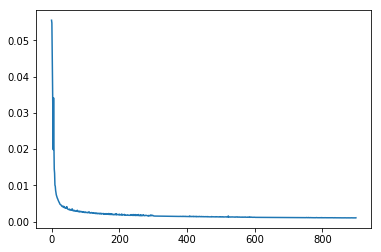

In [8]:
plt.plot(loss_arr)

In [9]:
np.save('{}/latent_train'.format(Dataset.main),Dataset.latent)

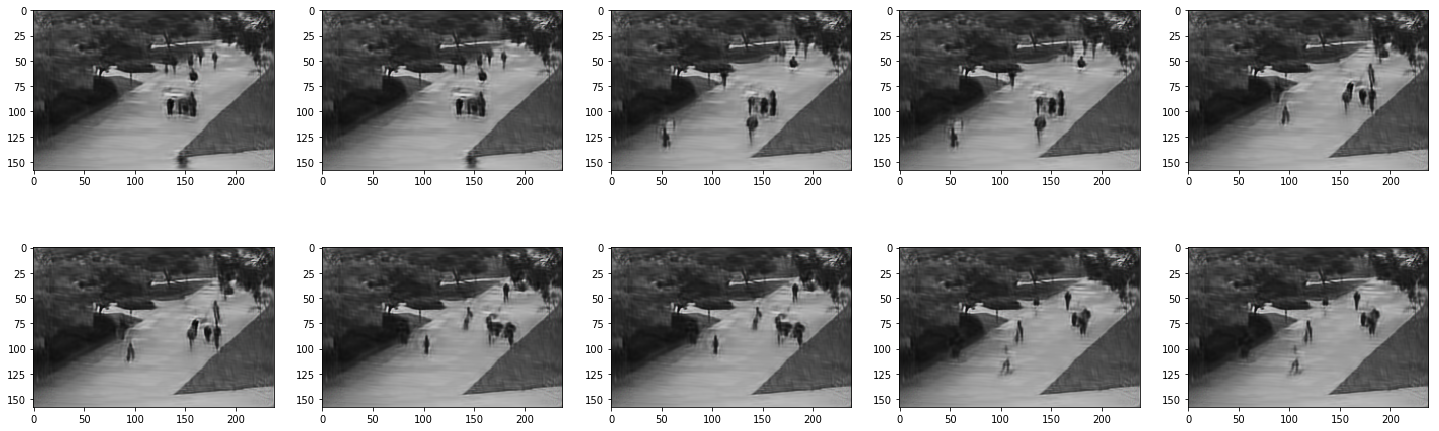

In [10]:
fig, axs = plt.subplots(2,5, figsize=(25,8))
axs = axs.ravel()

for i, imgs in enumerate(Dataset.reproduced_images[10:20]):
    axs[i].imshow(imgs[:,:,:])

In [11]:
axs[0].imshow(Dataset.reproduced_images[0,:,:])

In [12]:
Dataset.reproduced_images.shape

(20, 158, 238, 3)

In [13]:
Dataset.reproduced_images[0]

array([[[0.45432737, 0.45772445, 0.45752692],
        [0.4536947 , 0.4427813 , 0.42965075],
        [0.4210329 , 0.42382842, 0.41505983],
        ...,
        [0.20782112, 0.21263015, 0.23265162],
        [0.254821  , 0.26158223, 0.2838277 ],
        [0.36989027, 0.38904065, 0.40127414]],

       [[0.43715867, 0.4278079 , 0.46062633],
        [0.4622787 , 0.40820515, 0.4216214 ],
        [0.38028574, 0.4299755 , 0.38938954],
        ...,
        [0.16564737, 0.19468309, 0.17355114],
        [0.24538167, 0.1873692 , 0.22252779],
        [0.4067786 , 0.35673568, 0.3739106 ]],

       [[0.42727613, 0.4203888 , 0.45958564],
        [0.44401318, 0.3924824 , 0.38892585],
        [0.3427986 , 0.4290073 , 0.37795076],
        ...,
        [0.22482646, 0.23330346, 0.2115551 ],
        [0.23040201, 0.23507576, 0.2266184 ],
        [0.39916086, 0.4231843 , 0.3728554 ]],

       ...,

       [[0.4438537 , 0.4468217 , 0.44599056],
        [0.42800567, 0.42884168, 0.42763397],
        [0.43348414, 0

In [14]:
Dataset.test_images.shape

(400, 158, 238, 3)

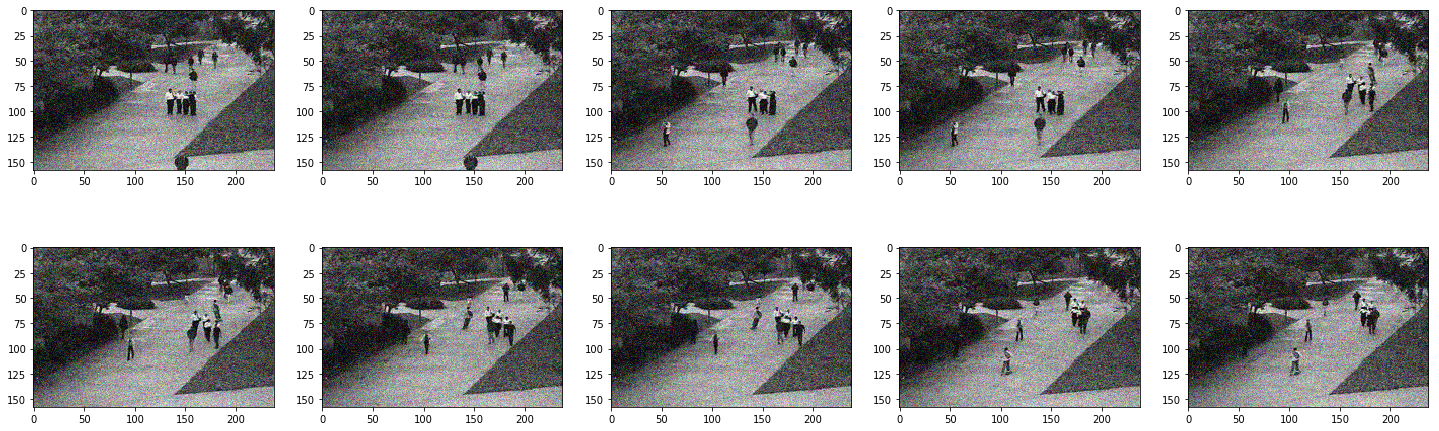

In [15]:
fig, axs = plt.subplots(2,5, figsize=(25,8))
axs = axs.ravel()

for i, imgs in enumerate(Dataset.test_images_[10:20]):
    axs[i].imshow(imgs[:,:,:])